# Dynamics experiments

In [43]:
%matplotlib inline

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import matplotlib.patches as pltp
from matplotlib.animation import FuncAnimation, PillowWriter
from numpy import exp, pi, array, asarray
from sympy.solvers import solve
from sympy import Symbol, Ellipse, Point, Line, Matrix, diff


## Analytical kinematics

In [45]:
def get_act(p1, p2, act_len):
    '''Get coordinates of the actuator based on two joints' positions'''
    dist = sp.sqrt((p1.x - p2.x) ** 2 + (p1.y - p2.y) ** 2)
    new_len = dist + act_len
    p12 = Point(new_len / dist * (p2 - p1) + p1)
    return p12

In [46]:
delta12 = (12, 0,)               # Distance between two mechanisms

w = 1
a1 = 5*np.pi/6                                  
l1 = .1                                      
R1, R2 = 1, 1.5
center1 = Point(0, 0)                            
center2 = Point(
    center1[0] + (R1 + R2 + l1)*np.cos(a1), 
    center1[1] + (R1 + R2 + l1)*np.sin(a1)
)
d1, d2 = 0.8, 1.4                                  
phi1, phi2 = 0, np.pi                              
act_len = 2

t_begin = 0
steps = 100
t_end = np.abs(4 * np.pi / w1)
dt = (t_end - t_begin) / steps
ts = np.linspace(t_begin, t_end, steps)
t = sp.Symbol('t')

In [47]:
# Position of revolute joints and end effectors
rev1 = Point(center1.x + d1 * sp.cos(w * t + phi1), center1.y + d1 * sp.sin(w * t + phi1))
rev2 = Point(center2.x + d2 * sp.cos(w * t + phi2), center2.y + d2 * sp.sin(w * t + phi2))
ee1 = get_act(rev1, rev2, act_len)

# Calculating angles of rods
rod_angle1 = sp.atan2(rev2.y - rev1.y, rev2.x - rev1.x)

In [48]:
# Precalculate all trajectories via substitution
rev1s = []
rev2s = []
ee1s = []
ra1s = []

for frame in ts:
    rev1s.append(rev1.subs(t, frame))
    rev2s.append(rev2.subs(t, frame))
    ee1s.append(ee1.subs(t, frame))
    ra1s.append(rod_angle1.subs(t, frame))
rev1s = np.array(rev1s, dtype=np.float64)
rev2s = np.array(rev2s, dtype=np.float64)
ee1s = np.array(ee1s, dtype=np.float64)
ra1s = np.array(ra1s, dtype=np.float64)

In [49]:
# Precisely calculate end-effector trajectory
# For better velocity calculation
# Not necessary

ee1s_precise = []
precision_dt = 0.07
precision_steps = int((t_end - t_begin) / precision_dt)

cur_time = 0
for _ in range(precision_steps):
    ee1s_precise.append(ee1.subs(t, cur_time))
    if len(ee1s_precise) > 1 and ee1s_precise[-1] == ee1s_precise[0]:
        break
    cur_time += precision_dt

ee1s_precise = np.array(ee1s_precise, dtype=np.float64)

## Dynamics


Let's consider a ball as a shpere with radius $R$ and density $\rho$

In [50]:
R_ball = 0.01   # m
pho_ball = 997 # kg / m**3

m_ball = 4/3 * np.pi * R_ball**3 * pho_ball
m_ball

0.004176223834172032

In [51]:
v_rev1 = sp.Matrix([sp.diff(coord, t) for coord in rev1])
v_rev2 = sp.Matrix([sp.diff(coord, t) for coord in rev2])
v_ee = sp.Matrix([sp.diff(coord, t) for coord in ee1])

In [52]:
a_rev1 = sp.diff(v_rev1, t)
a_rev2 = sp.diff(v_rev2, t)
a_ee = sp.diff(v_ee, t)

In [53]:
F_ee = m_ball * a_ee

In [56]:
# Precalculate all trajectories via substitution
F_ee_s = []

for frame in ts:
    F_ee_s.append(F_ee.subs(t, frame))

F_ee_s = np.array(F_ee_s, dtype=np.float64)

### Simulation

IndexError: list index out of range

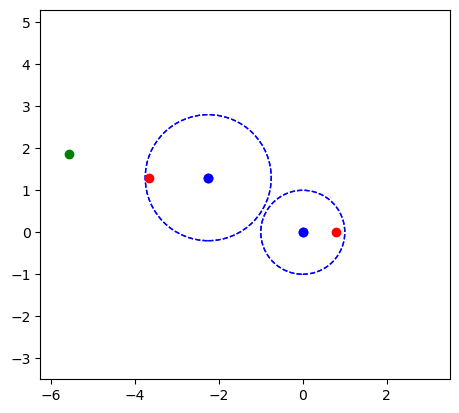

In [58]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
xdata, ydata = [], []
ln, = plt.plot([], [], 'g--')

trace = []
points = []
vectors = []
frames = []

prismatic_bar = plt.plot([], [], 'r-')
actuator_bar = plt.plot([], [], 'black')


def draw_vector(ax, X, Y, U, V, color):
    """Wrapper for drawing the proportional vectors"""
    return ax.quiver(X, Y, U, V, 
                     color = color, angles='xy', scale_units='xy',scale=1)


def init_frame():
    x_min = float(min(center1.x - R1, center2.x - R2) - act_len - 0.5)
    x_max = float(max(center1.x + R1, center2.x + R2) + act_len + 0.5)
    y_min = float(min(center1.y - R1, center2.y - R2) - act_len - 0.5)
    y_max = float(max(center1.y + R1, center2.y + R2) + act_len + 0.5)
    
    ax.set_xlim(x_min,x_max)
    ax.set_ylim(y_min,y_max)

    circle1 = pltp.Circle((center1.x, center1.y), R1, linestyle='--', color='b',fill=False)
    circle2 = pltp.Circle((center2.x, center2.y), R2, linestyle='--', color='b', fill=False)
    
    ax.add_patch(circle1)
    ax.add_patch(circle2)

    plt.plot(center1.x, center1.y, 'bo')
    plt.plot(center2.x, center2.y, 'bo')

    return ln,

# animation update on every frame
def update_frame(frame):
    for i in range(len(points)):
        points[i][0].remove()
    points.clear()

    frames.append(frame)
    idx = len(frames)-1

    for i in range(len(vectors)):
        vectors[i][0].remove()
    vectors.clear()

    points.append(plt.plot(rev1s[idx][0], rev1s[idx][1], 'ro'))
    points.append(plt.plot(rev2s[idx][0], rev2s[idx][1], 'ro'))
    points.append(plt.plot(ee1s[idx][0], ee1s[idx][1], 'go'))

    vectors.append(
        draw_vector(plt.axes, ee1s[idx][0], ee1s[idx][1], F_ee_s[idx][0], F_ee_s[idx][1], 'b')
    )

    prismatic_bar[0].set_data([rev1s[idx][0], rev2s[idx][0]], [rev1s[idx][1], rev2s[idx][1]])
    actuator_bar[0].set_data([rev2s[idx][0], ee1s[idx][0]], [rev2s[idx][1], ee1s[idx][1]])

    trace.append(ee1s[idx])
    ln.set_data([x[0] for x in trace], [x[1] for x in trace])
    return ln,

# create animation
anim = FuncAnimation(fig, update_frame, init_func=init_frame, frames=np.linspace(t_begin, t_end, steps), blit=True)

# save animation to the file
anim.save('assets/dynamics.gif', dpi=100, writer=PillowWriter(fps=60))
plt.close('all')
# plt.show()
# prevent unclosed plots